# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [2]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [3]:
df = pd.read_csv('/content/tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
32470,43735,88687,"Charlotte, NC",13-04-2020,Farmers are now starting to see the effects of...,Negative
24945,34336,79288,"Brussels, Belgium",06-04-2020,19 EPP would like to extend gratitude amp than...,Extremely Positive
11840,18166,63118,"Victoria, London",21-03-2020,What do you do if lose your job or get sick? \...,Positive
24312,33529,78481,NaN,05-04-2020,Mother fuckers planned this shit #Coronavirus ...,Extremely Negative


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [4]:
df['Sentiment'] = df['Sentiment'].apply(lambda x: 1 if x == "Positive" or x == "Extremely Positive" else 0)

Сбалансированы ли классы?

In [5]:
def is_balanced(df, column):
  max_observations = max(df[column].value_counts())
  min_observations = min(df[column].value_counts())
  diff = round((max_observations - min_observations) / max_observations * 100)
  print(f"Difference between the largest and smallest categories: {diff}%")
  return diff <= 30


In [6]:
is_balanced(df, 'Sentiment')

Difference between the largest and smallest categories: 15%


True

**Ответ:** Классы сбалансированны

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [7]:
df.isna().sum().to_frame("Number of null values in test")

,Number of null values in test
UserName,0
ScreenName,0
Location,7049
TweetAt,0
OriginalTweet,0
Sentiment,0


In [8]:
df['Location'] = df['Location'].fillna("Unknown")

Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [9]:
X = df.drop('Sentiment', axis=1)
y = df['Sentiment']

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)


## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [11]:
from collections import Counter
all_tokens = ' '.join(X_train['OriginalTweet']).lower().split()
token_counts = Counter(all_tokens)

token_counts_dict = dict(token_counts)


Какой размер словаря получился?

In [12]:
len(token_counts_dict)

79755

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [13]:
for word, count in Counter(token_counts_dict).most_common(10):
    print(f'{word}: {count}')


the: 26815
to: 23373
and: 14684
of: 13012
a: 11737
in: 11198
for: 8566
#coronavirus: 8223
is: 7383
are: 7050


**Ответ:** большую часть топа составляют предлоги и артикли (такие как the и of), это обусловлено особенностью английской грамматики. Также в топе есть хэштег - #coronavirus, потому что данный датасет описывает твиты про коронавирус

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [14]:
import nltk
from nltk.corpus import stopwords
from collections import Counter

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
filtered_token_counts = {token: count for token, count in token_counts_dict.items() if token not in stop_words}


for word, count in Counter(filtered_token_counts).most_common(10):
    print(f'{word}: {count}')




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#coronavirus: 8223
prices: 3891
food: 3820
grocery: 3469
supermarket: 3288
people: 3175
covid-19: 3173
store: 3155
#covid19: 2471
&amp;: 2314


**Ответ:**  топ содержит несколько упоминаний коронавируса в различных формах, а также слов, тесно связанных с тематикой коронавируса

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [15]:
for word, count in Counter(filtered_token_counts).most_common()[:-21:-1]:
    print(f'{word}: {count}')

https://t.co/7j2y3rsld9: 1
@680news: 1
@torontopearson: 1
nothing...: 1
flew: 1
wage!: 1
renewing: 1
playersãâ: 1
subsidise: 1
non-playing: 1
premiership: 1
https://t.co/iaek4fwsgz: 1
@srinivasiyc: 1
https://t.co/zjcl195vqs: 1
#southkerry: 1
#skelligcoast2kms: 1
@skelligsix18: 1
closer!): 1
coast!: 1
skellig: 1


**Ответ:** самые непопулярные слова представляют из себя ссылки, теги, слова со специальными символами, а также специфичную редко встречающуюся лексику (subsidise)



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [16]:
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer()
tokens = [token.lower() for tweet in X_train['OriginalTweet'] for token in tokenizer.tokenize(tweet)]

token_counts = Counter(tokens)

popular_tokens = Counter(token_counts).most_common(10)

for word, count in popular_tokens:
    print(f'{word}: {count}')



the: 26993
.: 24118
to: 23478
,: 17571
and: 14825
of: 13044
a: 11891
in: 11348
?: 9524
#coronavirus: 8808


**Ответ:** теперь среди токенов появились знаки пунктуации

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [17]:
from string import punctuation
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

tokenizer = TweetTokenizer()

stop_words = set(stopwords.words('english'))
punctuation_symbols = set(punctuation)


all_tokens = [token.lower() for tweet in X_train['OriginalTweet'] for token in tokenizer.tokenize(tweet)
              if token.lower() not in stop_words and token.lower() not in punctuation_symbols]

token_counts = Counter(all_tokens)
popular_tokens = Counter(token_counts).most_common(10)

for word, count in popular_tokens:
    print(f'{word}: {count}')


#coronavirus: 8808
â: 7415
: 7311
19: 7167
covid: 6253
prices: 4601
: 4372
food: 4367
store: 3877
supermarket: 3805


**Ответ:** в топе токенов есть служебные символы и числа наряду с популярными словами

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [18]:
token_counts = dict(token_counts)

filtered_token_counts = {token: count for token, count in token_counts.items() if not(len(token) == 1 and ord(token) >= 1)}

In [19]:
popular_tokens = Counter(filtered_token_counts).most_common(10)

for word, count in popular_tokens:
    print(f'{word}: {count}')

#coronavirus: 8808
19: 7167
covid: 6253
prices: 4601
food: 4367
store: 3877
supermarket: 3805
grocery: 3523
people: 3463
#covid19: 2589


**Ответ:** в полученном топе больше нет значений типа &amp;, а также новая токенизация лучше обрабатывает пунктуацию, поэтому одно и то же слово, после которого идут разные знаки пунктуации теперь обрабатывается как один и тот же токен, но при этом одиним из самых популярных токенов стало число 19, которое само по себе не несёт определённого смысла и популярно лишь потом что содержалось в слове covid-19

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [20]:
import re
from collections import Counter

def get_popular_tokens(token_counts_dict, pattern, entries_count):
    regex_pattern = re.compile(pattern)
    filtered_tokens = {token: count for token, count in token_counts_dict.items() if re.match(regex_pattern, token)}
    popular_tokens = Counter(filtered_tokens).most_common(entries_count)

    return popular_tokens

In [21]:
sample_size = 10

popular_hashtags = get_popular_tokens(
    token_counts_dict,
    r'#\w+',
    sample_size
)

print("Top 10 hashtags:")
for hashtag, count in popular_hashtags:
    print(f'{hashtag}: {count}')

Top 10 hashtags:
#coronavirus: 8223
#covid19: 2471
#covid_19: 1660
#covid2019: 915
#toiletpaper: 691
#socialdistancing: 427
#coronacrisis: 423
#covid?19: 418
#coronaviruspandemic: 245
#pandemic: 232


**Ответ:** самые популярные хэштеги укзывают тему твита - коронавирус и пандемия. Другие хэштеги из топа относятся к темам, которые были наиболее актуальны в период пандемии, например туалетная бумага :)

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [22]:
popular_urls = get_popular_tokens(
    token_counts_dict,
    r'https://t\.co/\w+',
    sample_size
)

print("\nTop 10 URLs:")
for url, count in popular_urls:
    print(f'{url}: {count}')


Top 10 URLs:
https://t.co/oxa7swtond: 5
https://t.co/gp3eusapl8: 4
https://t.co/deftrui1pfãâ: 3
https://t.co/wrlhyzizaa: 3
https://t.co/kuwipf1kqw: 3
https://t.co/zjnrx6dkkn: 3
https://t.co/3gbbdpdjat: 3
https://t.co/e2znxajpre: 3
https://t.co/catkegayoy: 3
https://t.co/g63rp042ho: 3


**Ответ:**

*   Популярность ссылок значительно ниже популярности хештегов, что ожидаемо - хэштеги используются для обозначения общей темы, которая может зачастую совпдать, в то время, когда ссылки используются в более спецефичных сценариях, например если нужно привести источник информации.  
*   В рамках нашего исследования информация о ссылках на кокретные страницы не будет полезна.





Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [23]:
from nltk.tokenize import TweetTokenizer

def custom_tokenizer(text):
    url_pattern = re.compile(r'https://t\.co/\w+')

    text_lower = text.lower()

    tokenizer = TweetTokenizer()
    raw_tokens = tokenizer.tokenize(text_lower)
    stop_words = set(stopwords.words('english'))
    punctuation_symbols = set(punctuation)

    tokens = [token for token in raw_tokens
              if token not in stop_words
              and token not in punctuation_symbols
              and not re.match(url_pattern, token)
              and not(len(token) == 1 and ord(token) >= 128)]
    return tokens


In [24]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(tokenizer=custom_tokenizer)

count_vectorizer.fit(X_train['OriginalTweet'])
X_train_counts = count_vectorizer.transform(X_train['OriginalTweet'])

print(len(count_vectorizer.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


45309


**Ответ:**

*   Размер словаря из задания №2: 79755  
*   Новый размер словаря: 45309

В словаре, полученном с использованием кастомного токенайзера меньше пар ключ-значение.



Посмотрим на какой-нибудь конкретный твитт:

In [26]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [27]:
tweet_text = train.iloc[ind]['OriginalTweet']

text_vectorized = count_vectorizer.transform([tweet_text])
text_vector_array = text_vectorized.toarray()[0]

nonzero_indices = text_vectorized.nonzero()[1]
vocab = count_vectorizer.get_feature_names_out()

nonzero_entries = zip(nonzero_indices, vocab[nonzero_indices], text_vector_array[nonzero_indices])
df_nonzero = pd.DataFrame(nonzero_entries, columns=['Index', 'Token', 'Vectorized component value'])
pd.set_option('display.precision', 3)
display(df_nonzero)

max_nonzero_index = nonzero_indices[np.argmax(text_vector_array[nonzero_indices])]
min_nonzero_index = nonzero_indices[np.argmin(text_vector_array[nonzero_indices])]

most_important_token = vocab[max_nonzero_index]
least_important_token = vocab[min_nonzero_index]

print("Most important token:", most_important_token)
print("Least important token:", least_important_token)


,Index,Token,Vectorized component value
0,1833,#coronavirusoutbreak,1
1,2046,#covid2019,1
2,16658,@skynews,1
3,20553,brainless,1
4,26665,ffs,1
5,27042,food,1
6,27233,france,1
7,31580,lets,1
8,34080,nice,1
9,34689,one,1


Most important token: #coronavirusoutbreak
Least important token: #coronavirusoutbreak


**Ответ:** Самый важный и самый неважный токен определись плохо (они совпали). Так получилось, потому после векторизации данного текста токены получили компоненты либо 0, либо 1, а значит токен (среди тех у которых комонента ненулевая), компонента которого максимальна/минимальна совпал - его компонента равна 1

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)

X_train_tfidf = tfidf_vectorizer.fit(X_train['OriginalTweet'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [29]:
text_tfidf_vectorized = tfidf_vectorizer.transform([tweet_text])

text_tfidf_vector_array = text_tfidf_vectorized.toarray()[0]
nonzero_indices_tfidf = text_tfidf_vectorized.nonzero()[1]

vocab_tfidf = tfidf_vectorizer.get_feature_names_out()

nonzero_pairs = zip(nonzero_indices_tfidf, vocab_tfidf[nonzero_indices_tfidf], text_tfidf_vector_array[nonzero_indices_tfidf])
df_tfidf = pd.DataFrame(nonzero_pairs, columns=['Index', 'Token', 'Vectorized component value'])

pd.set_option('display.precision', 3)
display(df_tfidf)

max_nonzero_index_tfidf = nonzero_indices_tfidf[np.argmax(text_tfidf_vector_array[nonzero_indices_tfidf])]
min_nonzero_index_tfidf = nonzero_indices_tfidf[np.argmin(text_tfidf_vector_array[nonzero_indices_tfidf])]

most_important_token_tfidf = vocab_tfidf[max_nonzero_index_tfidf]
least_important_token_tfidf = vocab_tfidf[min_nonzero_index_tfidf]


print("Most important token (TF-IDF):", most_important_token_tfidf)
print("Least important token (TF-IDF):", least_important_token_tfidf)


,Index,Token,Vectorized component value
0,39920,show,0.244
1,37230,queueing,0.354
2,36414,ppl,0.255
3,35258,panic,0.148
4,34689,one,0.163
5,34080,nice,0.254
6,31580,lets,0.301
7,27233,france,0.320
8,27042,food,0.113
9,26665,ffs,0.324


Most important token (TF-IDF): brainless
Least important token (TF-IDF): food


**Ответ:** самый важный токен - brainless, самый неважный токен - food. В этот раз наиболее/наименее важные токены определились гораздо лучше, потому что теперь с токенами ассоциируются значения из даипазана [0; 1], а не просто два значения (0 и 1), как это было ранее

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [30]:
train[train['OriginalTweet'].apply(lambda x: 'great' in x) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
192,4035,48987,"San Diego, CA",16-03-2020,"What's a good way to support grocery store, me...",1
4066,8742,53694,"Adelaide, South Australia",18-03-2020,BREAKING: WeÃÂre giving supermarkets the opt...,1
342,4219,49171,"Boston, MA",16-03-2020,[THREAD] China's role in wildlife trade should...,1
21883,30511,75463,London,02-04-2020,Coronavirus career pivots: 'I now work in a su...,1
23519,32529,77481,"Moulton, England",05-04-2020,Well done James great front of store before we...,1
...,...,...,...,...,...,...
21960,30608,75560,Unknown,02-04-2020,@dino_melaye I commend your efforts so far in ...,1
23905,33018,77970,Unknown,05-04-2020,Absolutely brilliant idea amp a great use of a...,1
25907,35528,80480,Bay Area,07-04-2020,Afraid of tracking in the #coronavirus? Here a...,1
18987,26911,71863,Unknown,25-03-2020,@AmyPoythress I hope you &amp; your family rem...,1


Выберем твит с индексом 21883

In [31]:
ind = 21883
tweet_text = train.loc[ind]['OriginalTweet']

tweet_text

"Coronavirus career pivots: 'I now work in a supermarket' great story. Make yourself useful #coronavirus #COVID19 #hope2020 https://t.co/KEn8gE7i4k"

In [32]:
text_tfidf_vectorized = tfidf_vectorizer.transform([tweet_text])

text_tfidf_vector_array = text_tfidf_vectorized.toarray()[0]
nonzero_indices_tfidf = text_tfidf_vectorized.nonzero()[1]

vocab_tfidf = tfidf_vectorizer.get_feature_names_out()

nonzero_pairs = zip(nonzero_indices_tfidf, vocab_tfidf[nonzero_indices_tfidf], text_tfidf_vector_array[nonzero_indices_tfidf])
df_tfidf = pd.DataFrame(nonzero_pairs, columns=['Index', 'Token', 'Vectorized component value'])

pd.set_option('display.precision', 3)
display(df_tfidf)

max_nonzero_index_tfidf = nonzero_indices_tfidf[np.argmax(text_tfidf_vector_array[nonzero_indices_tfidf])]
min_nonzero_index_tfidf = nonzero_indices_tfidf[np.argmin(text_tfidf_vector_array[nonzero_indices_tfidf])]

most_important_token_tfidf = vocab_tfidf[max_nonzero_index_tfidf]
least_important_token_tfidf = vocab_tfidf[min_nonzero_index_tfidf]


print("Most important token (TF-IDF):", most_important_token_tfidf)
print("Least important token (TF-IDF):", least_important_token_tfidf)


,Index,Token,Vectorized component value
0,44913,work,0.199
1,43733,useful,0.339
2,41558,supermarket,0.132
3,41221,story,0.278
4,35983,pivots,0.423
5,32282,make,0.204
6,28156,great,0.233
7,22939,coronavirus,0.187
8,21265,career,0.423
9,4066,#hope2020,0.481


Most important token (TF-IDF): #hope2020
Least important token (TF-IDF): #coronavirus


**Ответ:** в данном твите TfidfVectorizer выделяет токен #hope2020 как наиболее важный. Этот токен дейстивтельно является очень важным (определяющим) для определения эмоциональной окраски твита: если человек упоминает в твите надежду, то скорее всего твит имеет положительную окраску.

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [33]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


count_vectorizer = CountVectorizer(tokenizer=custom_tokenizer)
X_train_count = count_vectorizer.fit_transform(X_train['OriginalTweet'])
X_test_count = count_vectorizer.transform(X_test['OriginalTweet'])

tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['OriginalTweet'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['OriginalTweet'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logistic_regression_count = LogisticRegression(max_iter=1000)
logistic_regression_tfidf = LogisticRegression(max_iter=1000)

logistic_regression_count.fit(X_train_count, y_train)
logistic_regression_tfidf.fit(X_train_tfidf, y_train)


train_pred_count = logistic_regression_count.predict(X_train_count)
test_pred_count = logistic_regression_count.predict(X_test_count)

train_pred_tfidf = logistic_regression_tfidf.predict(X_train_tfidf)
test_pred_tfidf = logistic_regression_tfidf.predict(X_test_tfidf)

train_accuracy_count = accuracy_score(y_train, train_pred_count)
test_accuracy_count = accuracy_score(y_test, test_pred_count)

train_accuracy_tfidf = accuracy_score(y_train, train_pred_tfidf)
test_accuracy_tfidf = accuracy_score(y_test, test_pred_tfidf)


print("Accuracy on training data (CountVectorizer):", train_accuracy_count)
print("Accuracy on testing data (CountVectorizer):", test_accuracy_count)
print("Accuracy on training data (TfidfVectorizer):", train_accuracy_tfidf)
print("Accuracy on testing data (TfidfVectorizer):", test_accuracy_tfidf)

Accuracy on training data (CountVectorizer): 0.9844510892780863
Accuracy on testing data (CountVectorizer): 0.8671516842734702
Accuracy on training data (TfidfVectorizer): 0.9253737718923537
Accuracy on testing data (TfidfVectorizer): 0.8531991229818616


**Ответ:** Лучший результат показал CountVectorizer - 0.984 и 0.867 для обучающей и тестовой выборок соответственно; для TfidfVectorizer эти значения составили 0.925 и 0.853  
Разрыв в 0.117 между долей правильных ответов на обучающей и тестовой выборках может говорить, что модель обученная с помощью CountVectorizer является в некоторой степени переобученной. Аналогичный вывод можно сделать и про TfidfVectorizer, но в этом случае проблема переобученности выражена гораздо слабее  
  
В целом, обе модели показали хорошие результаты

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [35]:
from nltk.stem import SnowballStemmer


def custom_stem_tokenizer(text):
    tokens = custom_tokenizer(text)
    stemmer = SnowballStemmer('english')
    stemmed_tokens = [stemmer.stem(token) for token in tokens]

    return stemmed_tokens

In [36]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [37]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
cv.fit(X_train['OriginalTweet'])

print(len(cv.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36653


**Ответ**

*   размер словаря без использования стемминга - 45309
*   размер словаря с использованием стемминга - 36653

Размер словаря ожидаемо уменьшился, так как формы одного и того же слова были приведены к некому общему основанию, а значит количество уникальных токенов сократилось




Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [38]:
count_vectorizer_stem = CountVectorizer(tokenizer=custom_stem_tokenizer)
X_train_count_stem = count_vectorizer_stem.fit_transform(X_train['OriginalTweet'])
X_test_count_stem = count_vectorizer_stem.transform(X_test['OriginalTweet'])

tfidf_vectorizer_stem = TfidfVectorizer(tokenizer=custom_stem_tokenizer)
X_train_tfidf_stem = tfidf_vectorizer_stem.fit_transform(X_train['OriginalTweet'])
X_test_tfidf_stem = tfidf_vectorizer_stem.transform(X_test['OriginalTweet'])

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logistic_regression_count_stem = LogisticRegression(max_iter=1000)
logistic_regression_tfidf_stem = LogisticRegression(max_iter=1000)

logistic_regression_count_stem.fit(X_train_count_stem, y_train)
logistic_regression_tfidf_stem.fit(X_train_tfidf_stem, y_train)


train_pred_count_stem = logistic_regression_count_stem.predict(X_train_count_stem)
test_pred_count_stem = logistic_regression_count_stem.predict(X_test_count_stem)

train_pred_tfidf_stem = logistic_regression_tfidf_stem.predict(X_train_tfidf_stem)
test_pred_tfidf_stem = logistic_regression_tfidf_stem.predict(X_test_tfidf_stem)

train_accuracy_count_stem = accuracy_score(y_train, train_pred_count_stem)
test_accuracy_count_stem = accuracy_score(y_test, test_pred_count_stem)

train_accuracy_tfidf_stem = accuracy_score(y_train, train_pred_tfidf_stem)
test_accuracy_tfidf_stem = accuracy_score(y_test, test_pred_tfidf_stem)


print("Accuracy on training data (CountVectorizer):", train_accuracy_count_stem)
print("Accuracy on testing data (CountVectorizer):", test_accuracy_count_stem)
print("Accuracy on training data (TfidfVectorizer):", train_accuracy_tfidf_stem)
print("Accuracy on testing data (TfidfVectorizer):", test_accuracy_tfidf_stem)

Accuracy on training data (CountVectorizer): 0.9718496369073045
Accuracy on testing data (CountVectorizer): 0.8672513454255532
Accuracy on training data (TfidfVectorizer): 0.9158479282357966
Accuracy on testing data (TfidfVectorizer): 0.8560892963922663


**Ответ:** Применение стемминга не дало заметного улучшения в качестве прогноза как на обучающей, так и на тестовой выборках. Тем не менее, использование стемминга может быть обосновано с той точки зрения, что теперь морфологически близкие токены в нашем словаре представлено меньшим количеством элементов - модель линейной регресси работает с меньшим числом параметров.

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [40]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, max_df=0.28).fit(X_train['OriginalTweet'])


print(len(cv_df.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36651


**Ответ:** подобранное значение, про котором размер словаря равен 36651,- max_df = 0.28. Значение получилось относительно небольшим, потому что токены, встречающиеся более чем 25% твитов в целом редки (если не учитывать пунктуацию, предлоги и другие отсеченные нами токены, не несущие значительной смысловой нагрузки)

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

Воспользуемся бинарным поиском для определения нужного значения min_df

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

target_vocab_size = 3700

left = 0
right = 0.1
tolerance = 1

cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=right).fit(X_train['OriginalTweet'])
vocab_size = len(cv_df.vocabulary_)

while abs(vocab_size - target_vocab_size) > tolerance:
    mid = (left + right) / 2

    cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=mid).fit(X_train['OriginalTweet'])
    vocab_size = len(cv_df.vocabulary_)

    print(f"min_df: {mid}, Dictionary size: {vocab_size}")

    if vocab_size < target_vocab_size:
        right = mid
    else:
        left = mid


optimal_min_df = (left + right) / 2

print("\nOptimal min_df value:", optimal_min_df)


min_df: 0.05, Dictionary size: 35
min_df: 0.025, Dictionary size: 102
min_df: 0.0125, Dictionary size: 246
min_df: 0.00625, Dictionary size: 538
min_df: 0.003125, Dictionary size: 996
min_df: 0.0015625, Dictionary size: 1662
min_df: 0.00078125, Dictionary size: 2591
min_df: 0.000390625, Dictionary size: 3931
min_df: 0.0005859375000000001, Dictionary size: 3172
min_df: 0.00048828125, Dictionary size: 3489
min_df: 0.000439453125, Dictionary size: 3700

Optimal min_df value: 0.0004638671875


Проверим качество модели

In [42]:
count_vectorizer_stem = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=optimal_min_df)
X_train_count_stem = count_vectorizer_stem.fit_transform(X_train['OriginalTweet'])
X_test_count_stem = count_vectorizer_stem.transform(X_test['OriginalTweet'])

tfidf_vectorizer_stem = TfidfVectorizer(tokenizer=custom_stem_tokenizer, min_df=optimal_min_df)
X_train_tfidf_stem = tfidf_vectorizer_stem.fit_transform(X_train['OriginalTweet'])
X_test_tfidf_stem = tfidf_vectorizer_stem.transform(X_test['OriginalTweet'])

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logistic_regression_count_stem = LogisticRegression(max_iter=1000)
logistic_regression_tfidf_stem = LogisticRegression(max_iter=1000)

logistic_regression_count_stem.fit(X_train_count_stem, y_train)
logistic_regression_tfidf_stem.fit(X_train_tfidf_stem, y_train)


train_pred_count_stem = logistic_regression_count_stem.predict(X_train_count_stem)
test_pred_count_stem = logistic_regression_count_stem.predict(X_test_count_stem)

train_pred_tfidf_stem = logistic_regression_tfidf_stem.predict(X_train_tfidf_stem)
test_pred_tfidf_stem = logistic_regression_tfidf_stem.predict(X_test_tfidf_stem)

train_accuracy_count_stem = accuracy_score(y_train, train_pred_count_stem)
test_accuracy_count_stem = accuracy_score(y_test, test_pred_count_stem)

train_accuracy_tfidf_stem = accuracy_score(y_train, train_pred_tfidf_stem)
test_accuracy_tfidf_stem = accuracy_score(y_test, test_pred_tfidf_stem)


print("Accuracy on training data (CountVectorizer):", train_accuracy_count_stem)
print("Accuracy on testing data (CountVectorizer):", test_accuracy_count_stem)
print("Accuracy on training data (TfidfVectorizer):", train_accuracy_tfidf_stem)
print("Accuracy on testing data (TfidfVectorizer):", test_accuracy_tfidf_stem)

Accuracy on training data (CountVectorizer): 0.9286629645450662
Accuracy on testing data (CountVectorizer): 0.8680486346422165
Accuracy on training data (TfidfVectorizer): 0.8976078598889363
Accuracy on testing data (TfidfVectorizer): 0.8586804863464221


**Ответ:** Качество модели не ухудшилось, при этом мы сократили число признаков, на который обучается линейная регрессия путём отсечения достаточно редких токенов

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [44]:
X_train_count_stem.shape

(23410, 3700)

In [45]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_count_stem)
X_test_scaled = scaler.transform(X_test_count_stem)


logistic_regression_scaled = LogisticRegression(max_iter=1000)
logistic_regression_scaled.fit(X_train_scaled, y_train)


weights = logistic_regression_scaled.coef_[0]


top_positive_indices = weights.argsort()[-10:][::-1]
top_negative_indices = weights.argsort()[:10]


feature_names = np.array(cv_df.get_feature_names_out())

top_positive_tokens = feature_names[top_positive_indices]
top_negative_tokens = feature_names[top_negative_indices]

top_positive_weights = weights[top_positive_indices]
top_negative_weights = weights[top_negative_indices]


print("Top 10 tokens with highest positive weights:")
print(top_positive_tokens)

print("\nTop 10 tokens with highest negative weights:")
print(top_negative_tokens)


Top 10 tokens with highest positive weights:
['hand' 'free' 'help' 'thank' 'like' 'best' 'pleas' 'great' 'safe'
 'support']

Top 10 tokens with highest negative weights:
['crisi' 'panic' 'scam' 'kill' 'crude' 'stop' 'fear' 'emerg' 'wtf' 'fight']


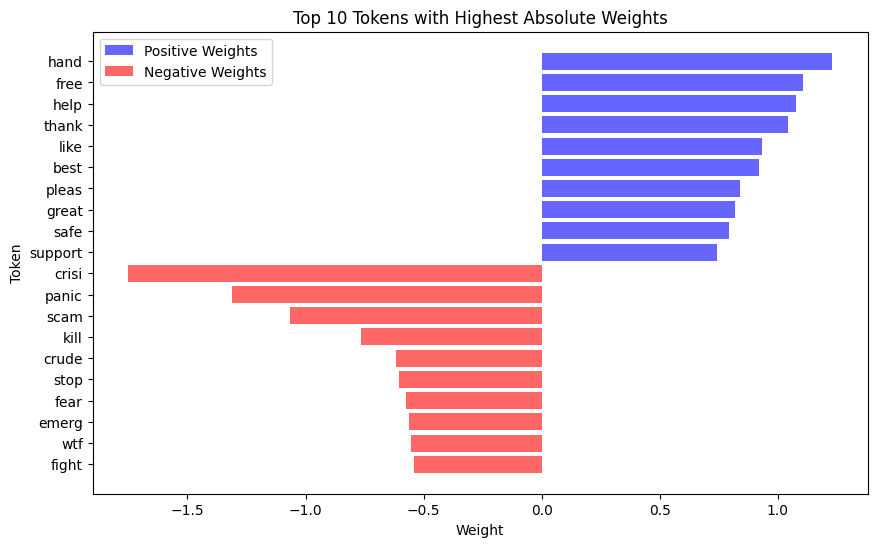

In [46]:
plt.figure(figsize=(10, 6))
plt.barh(top_positive_tokens, top_positive_weights, color='blue', alpha=0.6, label='Positive Weights')
plt.barh(top_negative_tokens, top_negative_weights, color='red', alpha=0.6, label='Negative Weights')
plt.xlabel('Weight')
plt.ylabel('Token')
plt.title('Top 10 Tokens with Highest Absolute Weights')
plt.legend()
plt.gca().invert_yaxis()
plt.show()

**Ответ:** можно заметить, что токены с наибольшими по модулю весами хорошо согласуются с общепринятыми представлениями об эмоциональной окраске текста, так среди токенов с сильно отрицательными весами мы видим ругательства, слова, наводящие панику и в целом негативно окрашенную лексику и наоборот - токены с наибольшим положительным весом ассоциированы с чем-то более приятным и внушающим уверенность: благодарности ('pleas', 'thank'), упоминания помощи ('help', 'support'), слова, сигнализирующие об удовлетворенности ситуацией ('like', 'best', 'great', 'safe')

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

Признаки UserName и ScreenName представляют собой имя пользователя и отображаемое имя пользователя, закодированные в числа неким образом. Обычно имя пользователя не представляет особого инетереса для анализа, а в нашем случае эти данные ещё и закодированы неким образом, про который мы ничего не знаем, поэтому скорее всего данные признаки не будут полезны в нашем исследовании.  

Не до конца понятно о каком дальнейшем кодировании этих признаков идёт речь, если они уже представлены в виде чисел. Можно лишь попробовать отмасштабировать их.

На всякий случай всё равно обучим модель с этими признаками и посмотрим на результаты

In [47]:
from scipy.sparse import hstack

user_screen_features_train = X_train[['UserName', 'ScreenName']]
user_screen_features_test = X_test[['UserName', 'ScreenName']]

X_train_combined = hstack([X_train_scaled, user_screen_features_train])
X_test_combined = hstack([X_test_scaled, user_screen_features_test])

In [48]:
logistic_regression_combined = LogisticRegression(max_iter=1000)
logistic_regression_combined.fit(X_train_combined, y_train)


train_pred_combined = logistic_regression_combined.predict(X_train_combined)
test_pred_combined = logistic_regression_combined.predict(X_test_combined)


train_accuracy_combined = accuracy_score(y_train, train_pred_combined)
test_accuracy_combined = accuracy_score(y_test, test_pred_combined)

print("Accuracy on train data with combined features:", train_accuracy_combined)
print("Accuracy on test data with combined features:", test_accuracy_combined)

Accuracy on train data with combined features: 0.9237078171721487
Accuracy on test data with combined features: 0.8517042057006179


**Ответ:** Чуда не произошло - качество модели не улучшилось, а значит признаки UserName и ScreenName бесполезны для нашей модели

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на оспнове целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [49]:
X_train['TweetAt'] = pd.to_datetime(X_train['TweetAt'], format='mixed')
X_test['TweetAt'] = pd.to_datetime(X_test['TweetAt'], format='mixed')

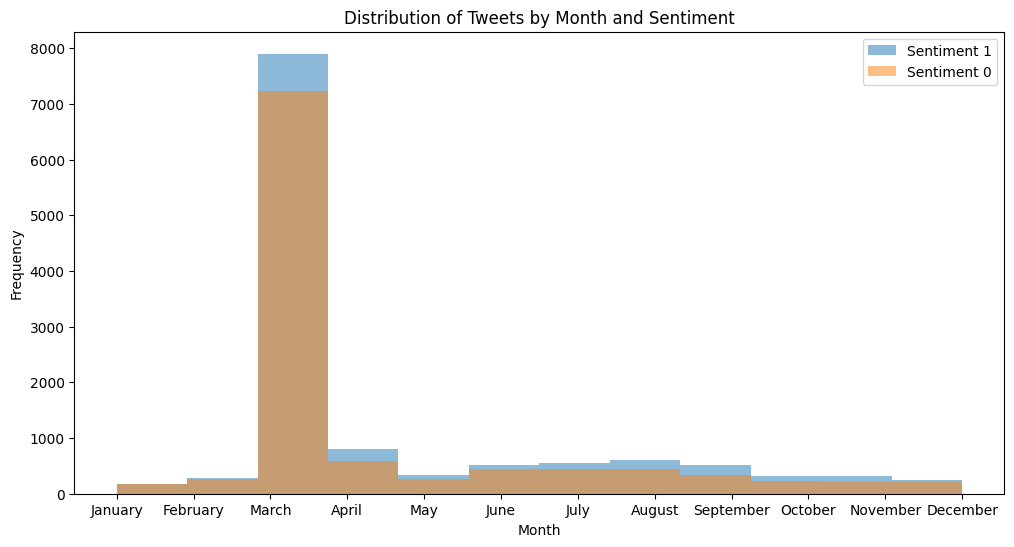

In [52]:
import matplotlib.pyplot as plt
import calendar

X_train['Month'] = X_train['TweetAt'].dt.month

plt.figure(figsize=(12, 6))
for sentiment in y_train.unique():
    plt.hist(X_train[y_train == sentiment]['Month'], bins=12, alpha=0.5, label=f'Sentiment {sentiment}')

plt.xlabel('Month')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Tweets by Month and Sentiment')


plt.xticks(ticks=range(1, 13), labels=[calendar.month_name[i] for i in range(1, 13)])
plt.show()


In [55]:
X_train['Month'] = X_train['TweetAt'].dt.month

class_ratios = pd.DataFrame(index=range(1, 13), columns=['Positive', 'Negative', 'Positive to negative ratio'])
for month in range(1, 13):
    total_count = X_train[X_train['Month'] == month].shape[0]
    if total_count > 0:
        class_ratios.loc[month, 'Positive'] = (y_train[X_train['Month'] == month] == 1).sum() / total_count
        class_ratios.loc[month, 'Negative'] = (y_train[X_train['Month'] == month] == 0).sum() / total_count
        class_ratios.loc[month, 'Positive to negative ratio'] = class_ratios.loc[month, 'Positive'] / class_ratios.loc[month, 'Negative']


display(class_ratios)


,Positive,Negative,Positive to negative ratio
1,0.51,0.49,1.041
2,0.516,0.484,1.065
3,0.522,0.478,1.092
4,0.578,0.422,1.367
5,0.559,0.441,1.266
6,0.539,0.461,1.168
7,0.554,0.446,1.244
8,0.58,0.42,1.378
9,0.599,0.401,1.491
10,0.585,0.415,1.412


Добавим номер месяца к матрице с признаками и обучим модель

In [66]:
from scipy.sparse import hstack


X_train['Month'] = X_train['TweetAt'].dt.month
X_test['Month'] = X_test['TweetAt'].dt.month


X_train_combined = hstack([X_train_scaled, X_train[['Month']]])
X_test_combined = hstack([X_test_scaled, X_test[['Month']]])

logistic_regression_combined = LogisticRegression(max_iter=1000)
logistic_regression_combined.fit(X_train_combined, y_train)


train_pred_combined = logistic_regression_combined.predict(X_train_combined)
test_pred_combined = logistic_regression_combined.predict(X_test_combined)


train_accuracy_combined = accuracy_score(y_train, train_pred_combined)
test_accuracy_combined = accuracy_score(y_test, test_pred_combined)


print("Accuracy on train data with combined features:", train_accuracy_combined)
print("Accuracy on test data with combined features:", test_accuracy_combined)

Accuracy on train data with combined features: 0.941648868005126
Accuracy on test data with combined features: 0.8448275862068966


**Ответ:** добавление признака TweetAt, а точнее месяца, в который был написан твит, не привело к увеличению качества модели



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [73]:
print(f'Number of unique locations (including Unknown): {len(X_train["Location"].unique())}')

Number of unique locations (including Unknown): 7949


Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

In [74]:
filtered_locations = X_train['Location'][X_train['Location'] != 'Unknown']
location_counts = filtered_locations.value_counts()
top_10_locations = location_counts.head(10)

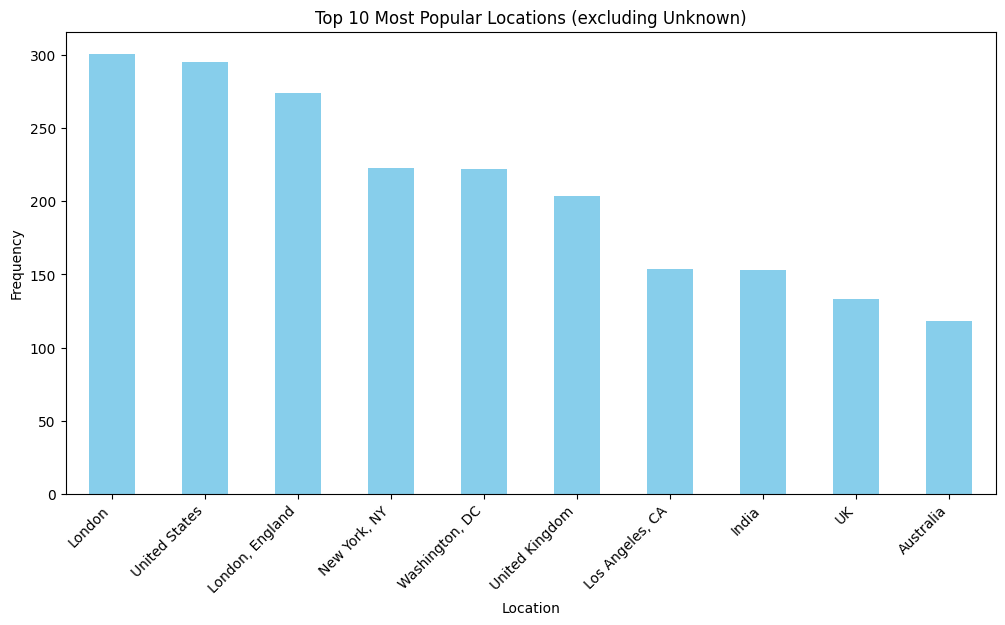

In [75]:
plt.figure(figsize=(12, 6))
top_10_locations.plot(kind='bar', color='skyblue')
plt.xlabel('Location')
plt.ylabel('Frequency')
plt.title('Top 10 Most Popular Locations (excluding Unknown)')
plt.xticks(rotation=45, ha='right')
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [79]:
def get_wider_location(location):
    if pd.isna(location) or location == 'Unknown':
        return 'Unknown'
    parts = location.split(',')
    return parts[-1].strip()

In [83]:
X_train['WiderLocation'] = X_train['Location'].apply(get_wider_location)
X_test['WiderLocation'] = X_test['Location'].apply(get_wider_location)
unique_wider_locations = X_train['WiderLocation'].nunique()
print(f"Number of unique wider locations: {unique_wider_locations}")

Number of unique wider locations: 4631


Количество уникальных категорий локации уменьшилось до 4631

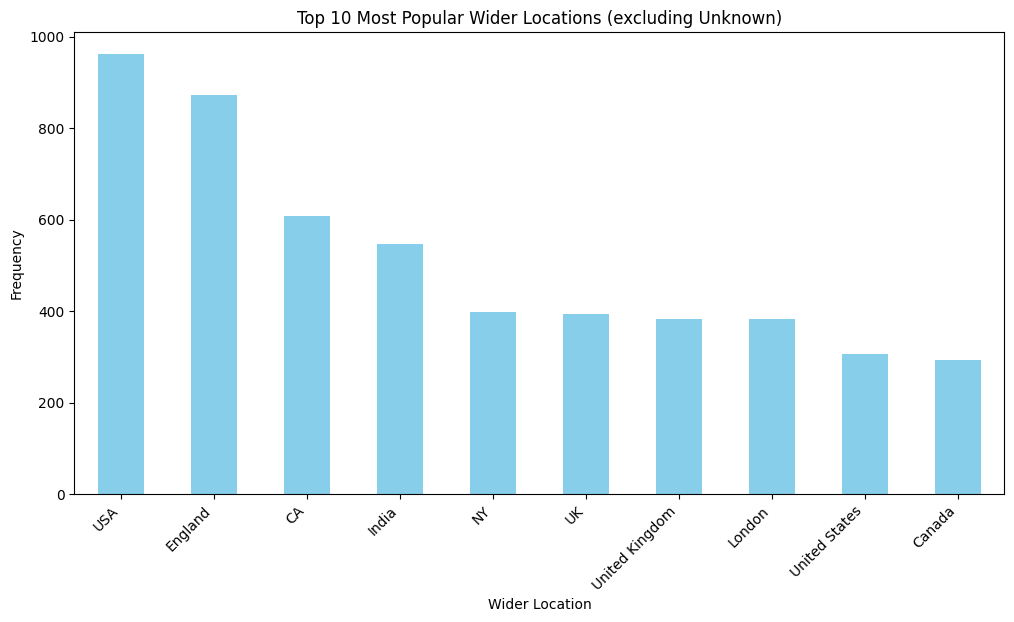

In [84]:
filtered_wider_locations = X_train['WiderLocation'][X_train['WiderLocation'] != 'Unknown']
wider_location_counts = filtered_wider_locations.value_counts()

top_10_wider_locations = wider_location_counts.head(10)

plt.figure(figsize=(12, 6))
top_10_wider_locations.plot(kind='bar', color='skyblue')
plt.xlabel('Wider Location')
plt.ylabel('Frequency')
plt.title('Top 10 Most Popular Wider Locations (excluding Unknown)')
plt.xticks(rotation=45, ha='right')
plt.show()

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [88]:
common_locations = X_train['WiderLocation'].value_counts()[X_train['WiderLocation'].value_counts() > 1].index.tolist()

X_train_ohe = pd.get_dummies(X_train[X_train['WiderLocation'].isin(common_locations)]['WiderLocation'])
X_test_ohe = pd.get_dummies(X_test[X_test['WiderLocation'].isin(common_locations)]['WiderLocation'])


unique_values_count = len(X_train_ohe.columns)
print("Number of unique locations that appear more than once:", unique_values_count)


Number of unique locations that appear more than once: 988


Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [91]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


encoder = OneHotEncoder(categories=[common_locations], sparse=False, handle_unknown='ignore')

X_train_encoded = encoder.fit_transform(X_train[['WiderLocation']])
X_test_encoded = encoder.transform(X_test[['WiderLocation']])

X_train_combined = hstack([X_train_scaled, X_train_encoded])
X_test_combined = hstack([X_test_scaled, X_test_encoded])

logistic_regression_combined = LogisticRegression(max_iter=1000)
logistic_regression_combined.fit(X_train_combined, y_train)

train_pred_combined = logistic_regression_combined.predict(X_train_combined)
test_pred_combined = logistic_regression_combined.predict(X_test_combined)

train_accuracy_combined = accuracy_score(y_train, train_pred_combined)
test_accuracy_combined = accuracy_score(y_test, test_pred_combined)


print("Accuracy on train data with combined features:", train_accuracy_combined)
print("Accuracy on test data with combined features:", test_accuracy_combined)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Accuracy on train data with combined features: 0.9457496796240923
Accuracy on test data with combined features: 0.8445286027506478


**Ответ:** # Качество снова не увеличилось (увеличилось только на обучающей выборке, что говорит о большей переобученности модели). Признак не оказался полезным... Есть ощущение, что я делаю что-то не так :(

## Задание 8 Хорошее качество (Бонус 1 балл)

Добейтесь accuracy=0.9 на тестовой выборке (можно сменить токенайзер, векторайзер, модель и т.д.)

In [102]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

vectorizer = CountVectorizer(tokenizer=custom_stem_tokenizer)

X_train_vectorized = vectorizer.fit_transform(X_train['OriginalTweet'])
X_test_vectorized = vectorizer.transform(X_test['OriginalTweet'])

Accuracy on training data: 0.9717214865442119
Accuracy on testing data: 0.8673510065776361


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [111]:
logistic_regression = LogisticRegression(max_iter=75, penalty='l2', C=0.3)


logistic_regression.fit(X_train_vectorized, y_train)

train_pred = logistic_regression.predict(X_train_vectorized)
test_pred = logistic_regression.predict(X_test_vectorized)

train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)


print("Accuracy on training data:", train_accuracy)
print("Accuracy on testing data:", test_accuracy)

Accuracy on training data: 0.944596326356258
Accuracy on testing data: 0.8704405022922065


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Точность на тестовой выборке составила 0.87 Почти получилось :(